<a href="https://colab.research.google.com/github/ciastirfry/Quantum_Computing/blob/main/task3_tic_tac_toe_quantum_code_figs_histfixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/ciastirfry/Quantum_Computing/blob/main/task3_tic_tac_toe_quantum_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 3: Investigate a quantum code (Quantum Tic-Tac-Toe)

### Author’s Name : Fredierick Saladas
### Student ID : 270609973@yoobeestudent.ac.nz
### College : Yoobee College of Creative Innovation
### Course : MSE802 Quantum Computing
### Supervisor : Dr. Arun Kumar
### Date : 15 November 2025

This notebook contains the completed and commented implementation for **Task 3: Investigate a quantum code**. It provides a playable quantum tic-tac-toe game built with Qiskit and Google Colab widgets.

In [1]:
# Install and import the required quantum-computing and widget libraries.
# qiskit-aer provides the simulator; pylatexenc is needed for the matplotlib circuit drawer.

!pip install qiskit-aer pylatexenc --quiet

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import (
    plot_histogram,
    plot_state_city,
    plot_bloch_multivector,
)

from google.colab import widgets
from ipywidgets import (
    interact,
    interactive,
    fixed,
    interact_manual,
    Button,
    Layout,
)
import ipywidgets

import pandas as pd
import numpy as np
import math
import random

from IPython.display import clear_output, display

import matplotlib.pyplot as plt
import time


In [2]:
class Board:
    """
    Board (model) for the quantum tic-tac-toe game.

    * Uses a 9-qubit QuantumCircuit (one qubit per square).
    * Keeps a classical view of the board in `self.tab` so we can
      reason about winners in the usual tic-tac-toe way.
    * Records how many times X and O have won across games.
    """
    def __init__(self):
        # 9 qubits, 9 classical bits – one pair per square
        self.qc = QuantumCircuit(9, 9)

        # Current action chosen in the UI: "Not", "O", "X", "SWAP" or "Measure"
        self.function = ''
        # Target square used only for SWAP (the first square the player clicks)
        self.target = -1

        # Classical representation of the board.
        # Each element is a dict: {"default": cell_index_as_str, "player": string_label}
        self.tab = []
        self.winsX = 0
        self.winsO = 0

        # Measurement and performance tracking
        self.last_counts = None
        self.last_backend = None
        self.last_runtime = None
        self.run_history = []  # list of dicts: {"backend", "shots", "runtime"}

        # Start every new game in a uniform superposition over all board states.
        for idx in range(0, 9):
            self.tab.append({"default": str(idx), "player": " "})
            self.qc.reset(idx)
            # Put each qubit into |+> = (|0> + |1>) / sqrt(2)
            self.qc.h(idx)
        # Barrier clearly separates initialisation from later moves.
        self.qc.barrier()

    # ------------------------------------------------------------------
    # Game actions – these are called from the driver / UI (Game class).
    # ------------------------------------------------------------------
    def make_move(self, cell: int) -> None:
        """
        Apply the currently selected operation (self.function) to a board
        cell and update the quantum circuit.

        The mapping used in this implementation is:
        * "Not"  – apply an X gate (bit-flip).
        * "O"    – rotate the qubit slightly towards |0> using an Ry rotation.
        * "X"    – rotate the qubit slightly towards |1> using an Ry rotation
                   in the opposite direction.
        * "SWAP" – swap the state of the chosen cell with the previously
                   selected `self.target` cell.
        """
        # Defensive guard: ignore out-of-range cells
        if cell < 0 or cell > 8:
            return

        if self.function == "Not":
            # A full bit-flip on the chosen qubit.
            self.qc.x(cell)
            self.tab[cell]["player"] += "N - "

        elif self.function == "O":
            # Small rotation towards |0>.
            # Starting from |+>, a negative rotation around Y pushes amplitude
            # towards |0>.
            self.qc.ry(-math.pi / 4, cell)
            self.tab[cell]["player"] += "O - "

        elif self.function == "X":
            # Small rotation towards |1>.
            self.qc.ry(math.pi / 4, cell)
            self.tab[cell]["player"] += "X - "

        elif self.function == "SWAP":
            # SWAP uses the `target` square that was captured by the Game
            # class when the user first clicked a cell after choosing SWAP.
            if self.target == -1:
                # No valid target has been stored – nothing to do.
                return

            if self.target == cell:
                # Second click on the same cell cancels the SWAP.
                self.target = -1
                return

            # Apply a SWAP gate between the target cell and the newly chosen cell.
            self.qc.swap(self.target, cell)
            self.tab[cell]["player"] += "S - "
            self.tab[self.target]["player"] += "S - "

            # Reset the target so a future SWAP starts fresh.
            self.target = -1

    # ------------------------------------------------------------------
    # Helper / utility methods
    # ------------------------------------------------------------------
    def results(self) -> None:
        """Draw the final circuit (matplotlib drawer) and reset it for the next round."""
        display(self.qc.draw('mpl'))
        # Start a fresh empty circuit for the next game if the user wants to replay.
        self.qc = QuantumCircuit(9, 9)

    def display(self) -> None:
        """Display the current quantum circuit using the matplotlib drawer."""
        display(self.qc.draw('mpl'))

    def measure(self, shots: int = 1024) -> None:
        """Measure all qubits and update the classical board.

        This version also records the raw counts and an approximate runtime
        so that histograms and runtime-comparison plots can be produced
        later from the notebook.

        Steps:
        * Add a measurement barrier and measure each qubit into the
          corresponding classical bit.
        * Run a simulation using AerSimulator with the requested number of shots.
        * Store counts, backend name and runtime in tracking attributes.
        * Update `self.tab` with classical X / O marks derived from the
          most probable bitstring.
        * Recompute the number of X and O wins using countWinners().
        """
        # Ensure no further gates cross the measurement boundary.
        self.qc.barrier()

        # Measure qubit i into classical bit i.
        for i in range(0, 9):
            self.qc.measure(i, i)

        # Time the AerSimulator execution.
        backend_name = "AerSimulator"
        start_time = time.time()
        simulator = AerSimulator()
        job = simulator.run(self.qc, shots=shots)
        result = job.result()
        counts = result.get_counts()
        end_time = time.time()

        runtime = end_time - start_time

        # Persist measurement statistics for later visualisation.
        self.last_counts = counts
        self.last_backend = backend_name
        self.last_runtime = runtime
        self.run_history.append(
            {"backend": backend_name, "shots": shots, "runtime": runtime}
        )

        # Use the most frequent bitstring as the outcome.
        output = max(counts, key=counts.get)

        # Qiskit returns bits in little-endian order, so we reverse the index.
        for i in range(0, 9):
            if output[9 - 1 - i] == "0":
                self.tab[i]["player"] = "X"
            else:
                self.tab[i]["player"] = "O"

        # Update score counters.

        self.winsX = self.countWinners("X")
        self.winsO = self.countWinners("O")

    def countWinners(self, player: str) -> int:
        """Count how many winning lines belong entirely to `player`.

        Winning lines are the 8 standard tic-tac-toe combinations:
        3 rows, 3 columns and 2 diagonals.
        """
        winners = (
            # Rows
            (0, 1, 2),
            (3, 4, 5),
            (6, 7, 8),
            # Columns
            (0, 3, 6),
            (1, 4, 7),
            (2, 5, 8),
            # Diagonals
            (0, 4, 8),
            (2, 4, 6),
        )

        wins = 0
        for line in winners:
            # Check whether all three squares in this line belong to `player`.
            if all(self.tab[idx]["player"] == player for idx in line):
                wins += 1
        return wins

    def new(self) -> None:
        """Reset both the classical board and the quantum circuit."""
        self.tab.clear()
        for idx in range(0, 9):
            self.tab.append({"default": str(idx), "player": " "})
            self.qc.reset(idx)
            self.qc.h(idx)
        self.qc.barrier()


In [3]:
class Game:
    """
    Driver / controller class for the quantum tic-tac-toe game.

    * Owns a `Board` instance that holds the quantum circuit and classical board.
    * Builds the UI using ipywidgets buttons for the 3×3 grid and the
      list of available quantum operations.
    * Handles all click events and forwards moves to the Board.
    """
    def __init__(self):
        # When True we are expecting the user to choose the SWAP target cell.
        self.selecting = False

        # Model object that contains the quantum circuit and game state.
        self.board = Board()

        # ------------------------------------------------------------------
        # Build the 3×3 grid of buttons – one for each board square.
        # ------------------------------------------------------------------
        self.boardbutton_list = []
        for i in range(9):
            button = Button(description=str(i))
            button.on_click(self.handle_game)
            self.boardbutton_list.append(button)

        # ------------------------------------------------------------------
        # Build the list of operation buttons the player can choose from.
        # ------------------------------------------------------------------
        self.funcbutton_list = []
        self.newButton("Measure")
        self.newButton("Not")
        self.newButton("O")
        self.newButton("X")
        self.newButton("SWAP")

        # Show the starting UI.
        self.printmenu()
        self.printBoard()

    def newButton(self, name: str) -> None:
        """Create an operation button and hook it up to the handler."""
        function = Button(description=name, layout=Layout(width="86px", height="30px"))
        function.on_click(self.handle_game)
        self.funcbutton_list.append(function)

    # ------------------------------------------------------------------
    # Event handling
    # ------------------------------------------------------------------
    def handle_game(self, b) -> None:
        """Main callback for *all* button clicks.

        * Operation buttons (Measure / Not / O / X / SWAP / Replay) enter the
          `except ValueError` branch, because their descriptions are not
          integers.
        * Board-square buttons (0–8) enter the `if int(b.description) >= 0`
          branch and are interpreted as cell indices.
        """
        try:
            # Board-square button: its description is an integer 0–8.
            if int(b.description) >= 0:
                if self.selecting:
                    # First click after selecting SWAP – remember the target
                    # square and wait for the second click.
                    self.board.target = int(b.description)
                else:
                    # Normal move: apply the chosen operation to this cell.
                    clear_output()
                    self.printmenu()
                    self.board.make_move(int(b.description))
                    self.printBoard()
                    self.board.display()

                # After processing a cell click we are no longer in
                # the SWAP-target selection phase.
                self.selecting = False

        except ValueError:
            # Any non-numeric button is one of the operation buttons.
            self.board.function = b.description
            self.selecting = False

            if self.board.function == "SWAP":
                # The *next* cell click will be used to choose the target.
                self.selecting = True

            elif self.board.function == "Measure":
                # Finalise the circuit, run the simulation and show scores.
                clear_output()
                self.replay()
                self.board.measure()
                self.scoreboard()
                self.printBoard()
                self.board.results()

            elif self.board.function == "Replay":
                # Start a completely new game with a fresh circuit and board.
                self.board.new()
                self.board.winsX = 0
                self.board.winsO = 0
                clear_output()
                self.printmenu()
                self.scoreboard()
                self.printBoard()

            # For Not / O / X we simply store the action in board.function
            # and wait for the user to click a board square.

    # ------------------------------------------------------------------
    # UI helpers
    # ------------------------------------------------------------------
    def printmenu(self) -> None:
        """Display the row of operation buttons."""
        grid = widgets.Grid(1, 5)
        for (row, col) in grid:
            display(self.funcbutton_list[col])

    def scoreboard(self) -> None:
        """Print the number of winning lines for X and O."""
        print(f"X wins: {self.board.winsX}    O wins: {self.board.winsO}")

    def replay(self) -> None:
        """Show a Replay button that starts a fresh game when clicked."""
        rep = Button(description="Replay")
        rep.on_click(self.handle_game)
        display(rep)

    def printBoard(self) -> None:
        """Render the 3×3 board with the current player labels."""
        grid = widgets.Grid(1, int(np.sqrt(9)), header_row=True, header_column=True)
        for row in range(int(np.sqrt(9))):
            for (unused, col) in grid:
                idx = col + row * int(np.sqrt(9))
                print("\n" + self.board.tab[idx]["player"] + "\n")
                display(self.boardbutton_list[idx])


## Create and start the game

**How to run the quantum tic-tac-toe game in this notebook:**

1. Run all the cells *above* this section in order (imports, `Board`, and `Game`).
2. Run the code cell directly below. This will create a `Game` object and display the UI.

**How to play:**

- The 3×3 grid of grey buttons represents the tic-tac-toe board (cells 0–8).
- The top row of buttons (`Measure`, `Not`, `O`, `X`, `SWAP`) selects the **quantum operation** you want to apply.
- To make a move:
  1. Click an operation button (for example, `X`).
  2. Then click a board cell (0–8). The chosen gate is added to that cell's qubit.
- You can repeat this process to build up a sequence of quantum moves on different cells.
- `SWAP` is a two-step move: after clicking `SWAP`, click the **first** cell to mark it as the swap target, then click the **second** cell to swap their quantum states.
- When you are satisfied with the circuit, click `Measure`. The game will:
  - Measure all 9 qubits.
  - Convert the measurement result into Xs and Os on the board.
  - Count how many winning lines belong to X and O and print the scores.
- After a measurement, press `Replay` to reset the board and start a completely new game with a fresh quantum circuit.

Button(description='Replay', style=ButtonStyle())

X wins: 2    O wins: 1


,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


X



Button(description='0', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


X



Button(description='1', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


X



Button(description='2', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


X



Button(description='3', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


X



Button(description='4', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


X



Button(description='5', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


O



Button(description='6', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


O



Button(description='7', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


O



Button(description='8', style=ButtonStyle())

<IPython.core.display.Javascript object>

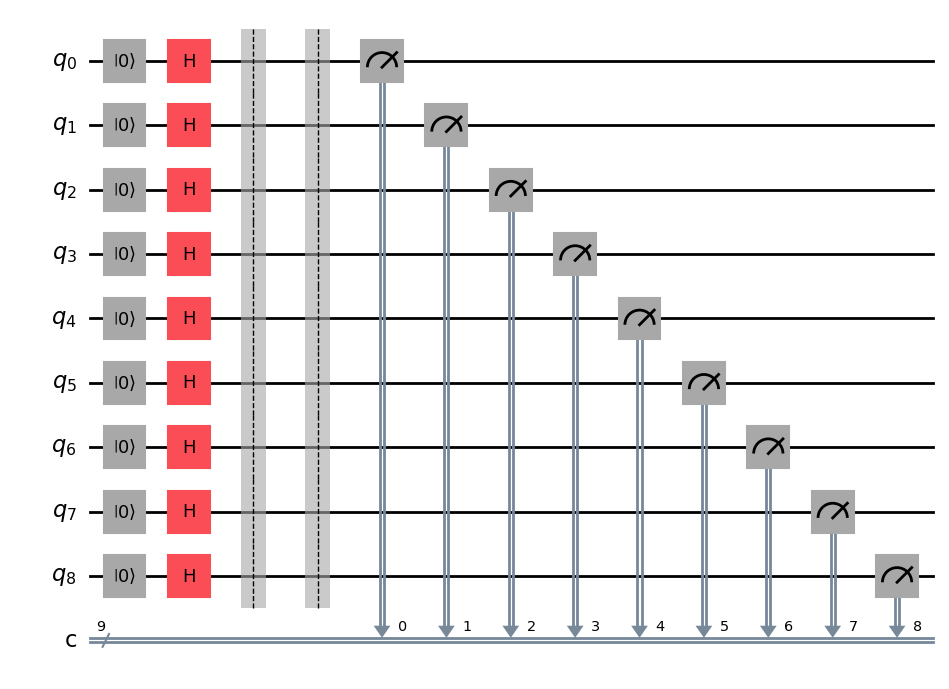

In [4]:
# Create and start the game.
# After you have run all the previous cells, run this cell once.
# A widget-based UI will appear above the output area.
# Use the instructions in the markdown cell to choose operations and click cells.
game = Game()


## Optional analysis cells for figures

The following cells help you capture the diagrams and plots referenced in the Task 3 report.

- **Figure 1 – Notebook user interface:** after you create the game (`game = Game()`), take a screenshot that shows the 3×3 board, the operation buttons and the Replay button.
- **Figure 2 – Quantum circuit after a sample game:** run the cell below after playing at least one game.
- **Figure 3 – Measurement outcome histogram:** run the histogram cell after you have pressed **Measure** at least once.
- **Figure 4 – Backend runtime comparison:** runs on the `run_history` entries recorded during each measurement.


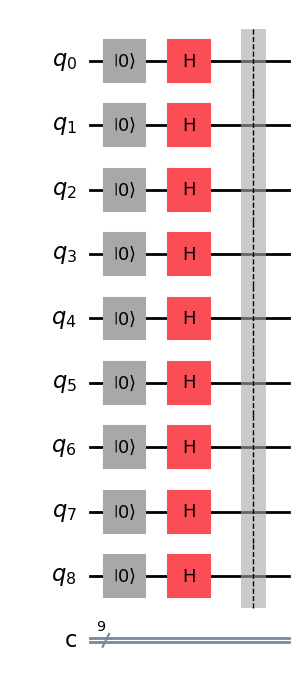

In [5]:
# Figure 2 – Quantum circuit after a sample game
# Run this cell after you have played at least one game
# and pressed Measure at least once.
try:
    game.board.display()
except NameError:
    print("Please run the cell that creates the Game first (game = Game()).")


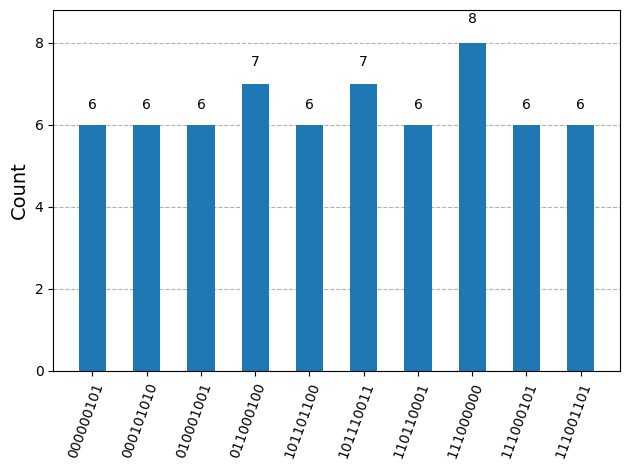

In [8]:
# Figure 3 – Measurement outcome histogram
# Requires that Board.measure() has been called at least once.

if 'game' not in globals():
    print("Please run the cell that creates the Game first (game = Game()).")
elif game.board.last_counts is None:
    print("No measurement data available yet. Play a game and click Measure, then run this cell again.")
else:
    # Many different bitstrings can appear, which makes the full histogram
    # visually crowded. To keep the figure readable we show only the top-N
    # most frequent outcomes.
    counts = game.board.last_counts
    # Sort outcomes by descending count
    items = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)
    top_n = 10  # change this if you want more or fewer bars
    top_items = dict(items[:top_n])

    # Plot a compact histogram of the dominant outcomes.
    hist = plot_histogram(top_items)
    display(hist)


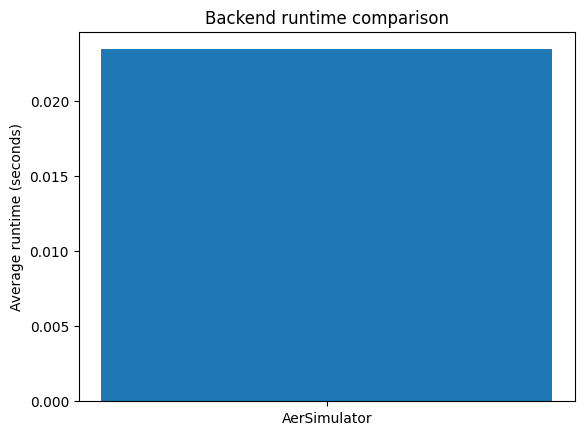

In [9]:
# Figure 4 – Backend runtime comparison (optional)
# Uses the run_history recorded inside the Board object.
# In this version all entries come from the Aer simulator, but if you
# later add a Quokka backend you can extend the tracking to include it.

if 'game' not in globals():
    print("Please run the cell that creates the Game first (game = Game()).")
elif not game.board.run_history:
    print("No runtime data recorded yet. Play a game and click Measure a few times, then run this cell again.")
else:
    # Aggregate average runtime per backend label.
    runtimes = {}
    for entry in game.board.run_history:
        backend = entry.get("backend", "unknown")
        runtimes.setdefault(backend, []).append(entry.get("runtime", 0.0))

    labels = []
    avg_values = []
    for backend, values in runtimes.items():
        labels.append(backend)
        avg_values.append(sum(values) / len(values))

    fig, ax = plt.subplots()
    ax.bar(labels, avg_values)
    ax.set_ylabel("Average runtime (seconds)")
    ax.set_title("Backend runtime comparison")
    plt.show()
